<a href="https://colab.research.google.com/github/Navoditamathur/ImageCrackSegmentationWaveletUnet/blob/main/wave_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Wavelet Unet Crack Image Segmentation:
- Uses Unet-based architecture
- Densely cross-related features
- Self-attention mechanism

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/crack_segmentation_dataset.zip

Archive:  /content/drive/MyDrive/crack_segmentation_dataset.zip
replace __MACOSX/._crack_segmentation_dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from glob import glob

path_images = r'crack_segmentation_dataset/images/'
path_masks = r'crack_segmentation_dataset/masks/'

images_paths = glob(path_images + '*.jpg')
masks_paths = glob(path_masks + '*.jpg')

In [ ]:
images_paths = sorted([str(p) for p in images_paths])
masks_paths = sorted([str(p) for p in masks_paths])

df = pd.DataFrame({'images': images_paths, 'masks': masks_paths})

df.sample(2)

,images,masks
5380,crack_segmentation_dataset/images/Rissbilder_f...,crack_segmentation_dataset/masks/Rissbilder_fo...
7542,crack_segmentation_dataset/images/Rissbilder_f...,crack_segmentation_dataset/masks/Rissbilder_fo...


In [ ]:
seed = 42

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1, shuffle=True, random_state=seed)
print(f'Train size: {len(train_df)}, and test size: {len(test_df)}')

Train size: 4500, and test size: 500


In [ ]:
# Function to load and preprocess images
def load_and_preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (256, 256))  # Resize to 256x256
    img = tf.image.convert_image_dtype(img, tf.float32)  # Convert to float32
    return img

# Function to load and preprocess masks
def load_and_preprocess_mask(file_path):
    mask = tf.io.read_file(file_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (256, 256))  # Resize to 256x256
    mask = tf.image.convert_image_dtype(mask, tf.float32)  # Convert to float32
    mask = tf.where(mask >= 0.5, 1.0, 0.0)  # Threshold to convert to binary mask
    return mask

In [ ]:
test_img_ds = tf.data.Dataset.from_tensor_slices(test_df['images'])
test_mask_ds = tf.data.Dataset.from_tensor_slices(test_df['masks'])

In [ ]:
test_img_ds = test_img_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_mask_ds = test_mask_ds.map(load_and_preprocess_mask, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
test_dataset = tf.data.Dataset.zip((test_img_ds, test_mask_ds))

In [ ]:
BATCH_SIZE = 8
BUFFER_SIZE = 1000

In [ ]:
test_size = len(test_dataset)
test_batches = test_dataset.take(test_size).batch(BATCH_SIZE)

In [ ]:
from Wavelet_UNet import Wavelet_UNet, dice_coef, dice_coef_loss, iou_metric
from keras.optimizers import Adam

wavelet_unet_model = Wavelet_UNet()
wavelet_unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_67 (Conv2D)          (None, 256, 256, 32)         896       ['input_2[0][0]']             
                                                                                                  
 conv2d_68 (Conv2D)          (None, 256, 256, 32)         9248      ['conv2d_67[0][0]']           
                                                                                                  
 conv2d_69 (Conv2D)          (None, 256, 256, 32)         9248      ['conv2d_68[0][0]']           
                                                                                            

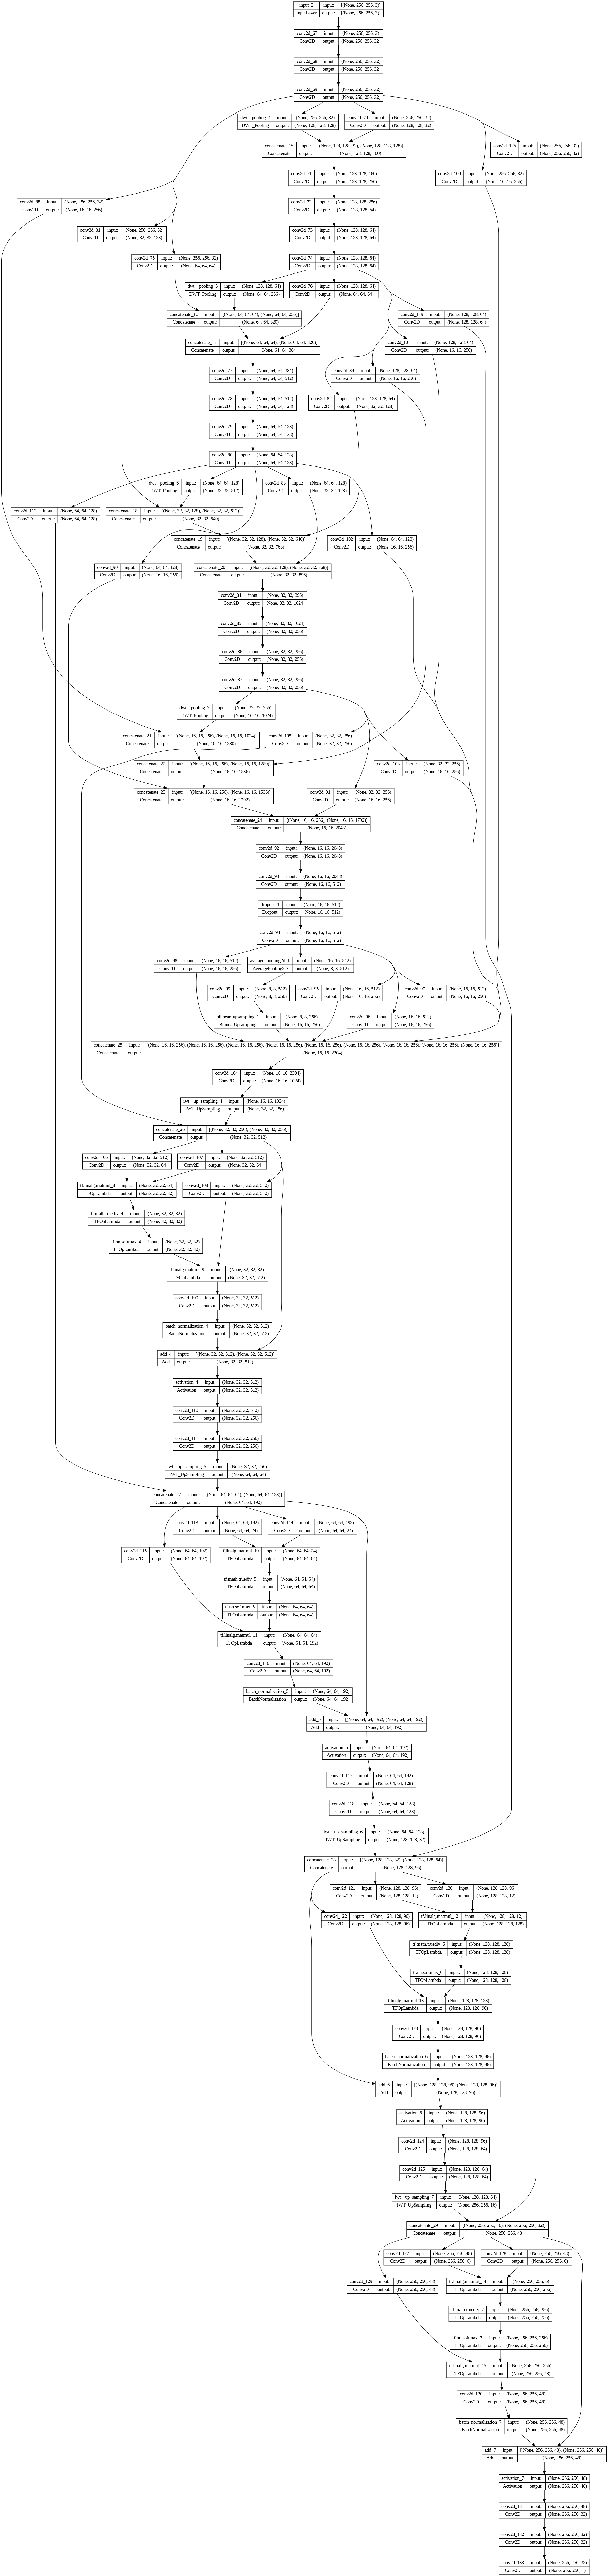

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(wavelet_unet_model, show_shapes=True)

In [34]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping

# Build the model
wavelet_unet_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=[dice_coef, iou_metric])

# Assuming len(test_dataset) is the total size of your test dataset
test_size = len(test_dataset)
test_batches = test_dataset.batch(BATCH_SIZE)
NUM_EPOCHS = 30
NUM_SPLITS = 5

all_fold_histories = []

# 5-fold Cross-Validation with Early Stopping
kf = KFold(n_splits=NUM_SPLITS, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kf.split(train_df)):
    print(f"Fold {fold + 1}")
    train = train_df.iloc[train_index]
    valid = train_df.iloc[val_index]

    # Create datasets for images and masks
    train_img_ds = tf.data.Dataset.from_tensor_slices(train_df['images'])
    train_mask_ds = tf.data.Dataset.from_tensor_slices(train_df['masks'])

    valid_img_ds = tf.data.Dataset.from_tensor_slices(train_df['images'])
    valid_mask_ds = tf.data.Dataset.from_tensor_slices(train_df['masks'])

    # Load and preprocess the images and masks
    train_img_ds = train_img_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_mask_ds = train_mask_ds.map(load_and_preprocess_mask, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    valid_img_ds = valid_img_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    valid_mask_ds = valid_mask_ds.map(load_and_preprocess_mask, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    fold_train_dataset = tf.data.Dataset.zip((train_img_ds, train_mask_ds))
    fold_val_dataset = tf.data.Dataset.zip((valid_img_ds, valid_mask_ds))

    # Set up batches for this fold
    fold_train_batches = fold_train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    fold_train_batches = fold_train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    fold_val_batches = fold_val_dataset.batch(BATCH_SIZE)

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    TRAIN_LENGTH = len(train)
    STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

    VAL_SUBSPLITS = 5
    VAL_LENGTH = len(valid)
    VALIDATION_STEPS = VAL_LENGTH // BATCH_SIZE // VAL_SUBSPLITS

    # Train the model for this fold
    fold_history = wavelet_unet_model.fit(
        fold_train_batches,
        epochs=NUM_EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_data=fold_val_batches,
        validation_steps=VALIDATION_STEPS,
        callbacks=[early_stopping]
    )

    all_fold_histories.append(fold_history)

    # Optionally, you can save the model for each fold
    wavelet_unet_model.save(f'model_fold_{fold + 1}')


Fold 1
Epoch 1/30
450/450 [==============================] - 290s 601ms/step - loss: 2.1385 - dice_coef: 0.1398 - iou_metric: 0.9558 - val_loss: 0.7930 - val_dice_coef: 0.1595 - val_iou_metric: 0.9565
Epoch 2/30
450/450 [==============================] - 268s 596ms/step - loss: 0.6907 - dice_coef: 0.2157 - iou_metric: 0.9559 - val_loss: 0.5322 - val_dice_coef: 0.2630 - val_iou_metric: 0.9711
Epoch 3/30
450/450 [==============================] - 268s 596ms/step - loss: 0.4692 - dice_coef: 0.3677 - iou_metric: 0.9599 - val_loss: 0.4030 - val_dice_coef: 0.3456 - val_iou_metric: 0.9695
Epoch 4/30
450/450 [==============================] - 268s 596ms/step - loss: 0.3643 - dice_coef: 0.4661 - iou_metric: 0.9649 - val_loss: 0.3222 - val_dice_coef: 0.4615 - val_iou_metric: 0.9657
Epoch 5/30
450/450 [==============================] - 268s 596ms/step - loss: 0.3099 - dice_coef: 0.5239 - iou_metric: 0.9656 - val_loss: 0.2806 - val_dice_coef: 0.5384 - val_iou_metric: 0.9682
Epoch 6/30
450/450 [===

In [35]:
history = wavelet_unet_model.history
wavelet_unet_model.save('wavelet_unet_model')

In [36]:
wavelet_unet_model.history.history.keys()

dict_keys(['loss', 'dice_coef', 'iou_metric', 'val_loss', 'val_dice_coef', 'val_iou_metric'])

Training history keys: dict_keys(['loss', 'dice_coef', 'iou_metric', 'val_loss', 'val_dice_coef', 'val_iou_metric'])


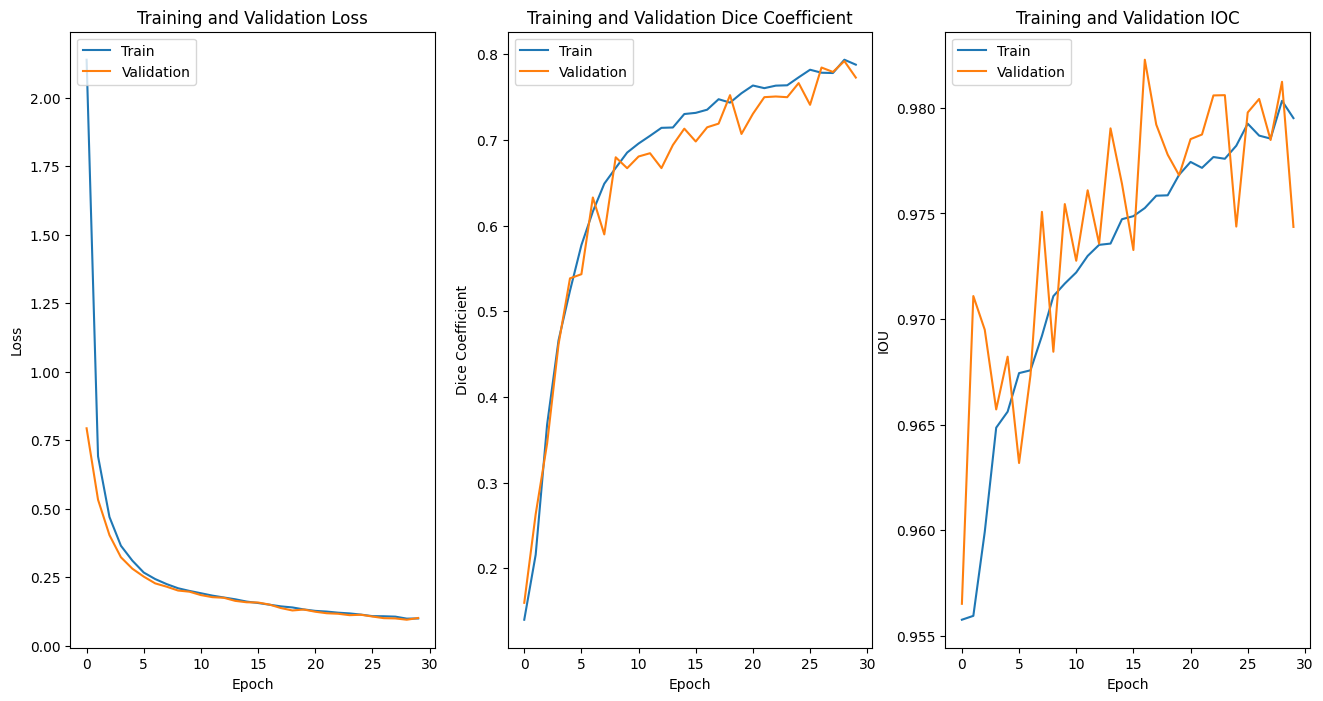

Training history keys: dict_keys(['loss', 'dice_coef', 'iou_metric', 'val_loss', 'val_dice_coef', 'val_iou_metric'])


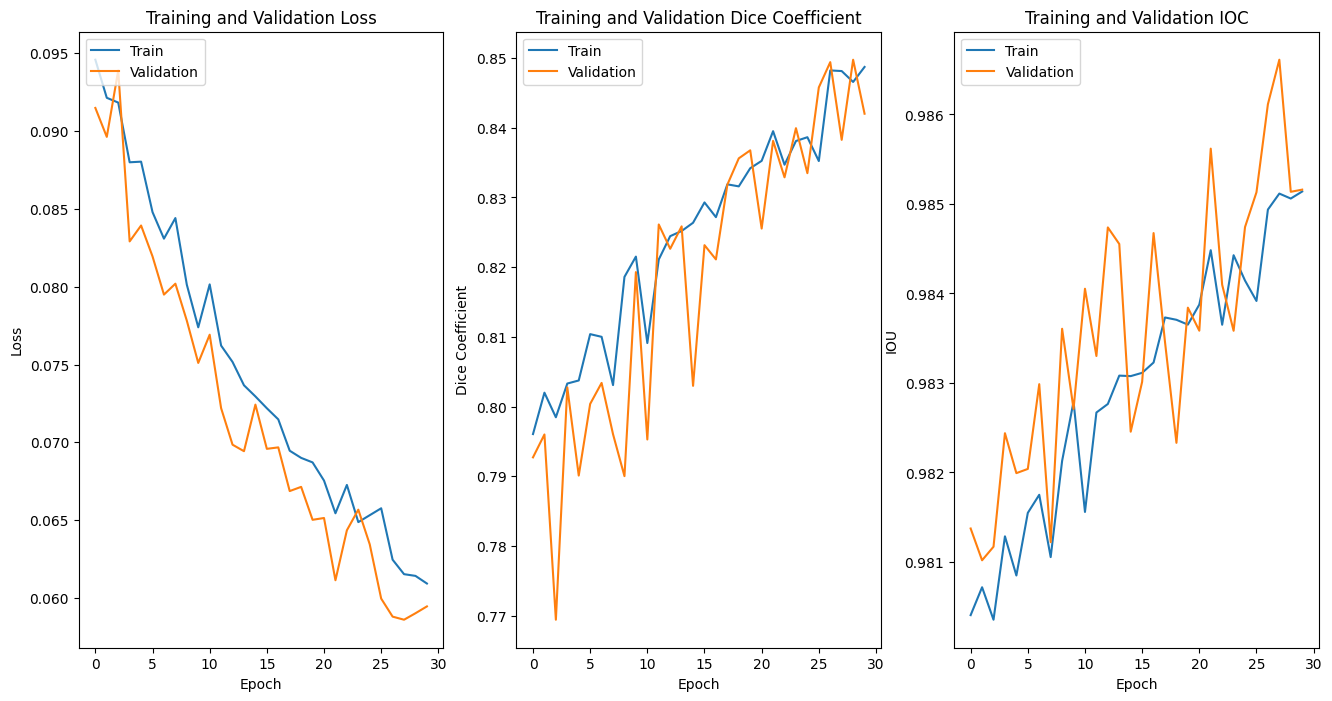

Training history keys: dict_keys(['loss', 'dice_coef', 'iou_metric', 'val_loss', 'val_dice_coef', 'val_iou_metric'])


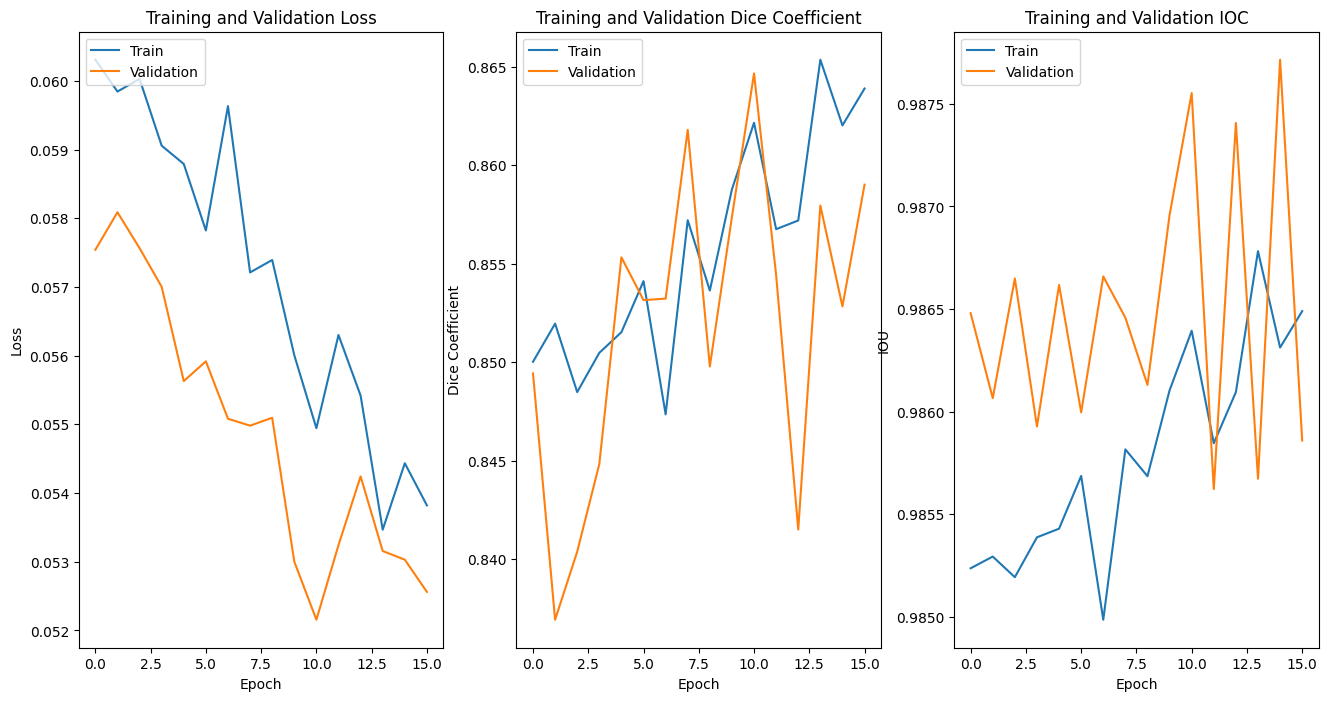

Training history keys: dict_keys(['loss', 'dice_coef', 'iou_metric', 'val_loss', 'val_dice_coef', 'val_iou_metric'])


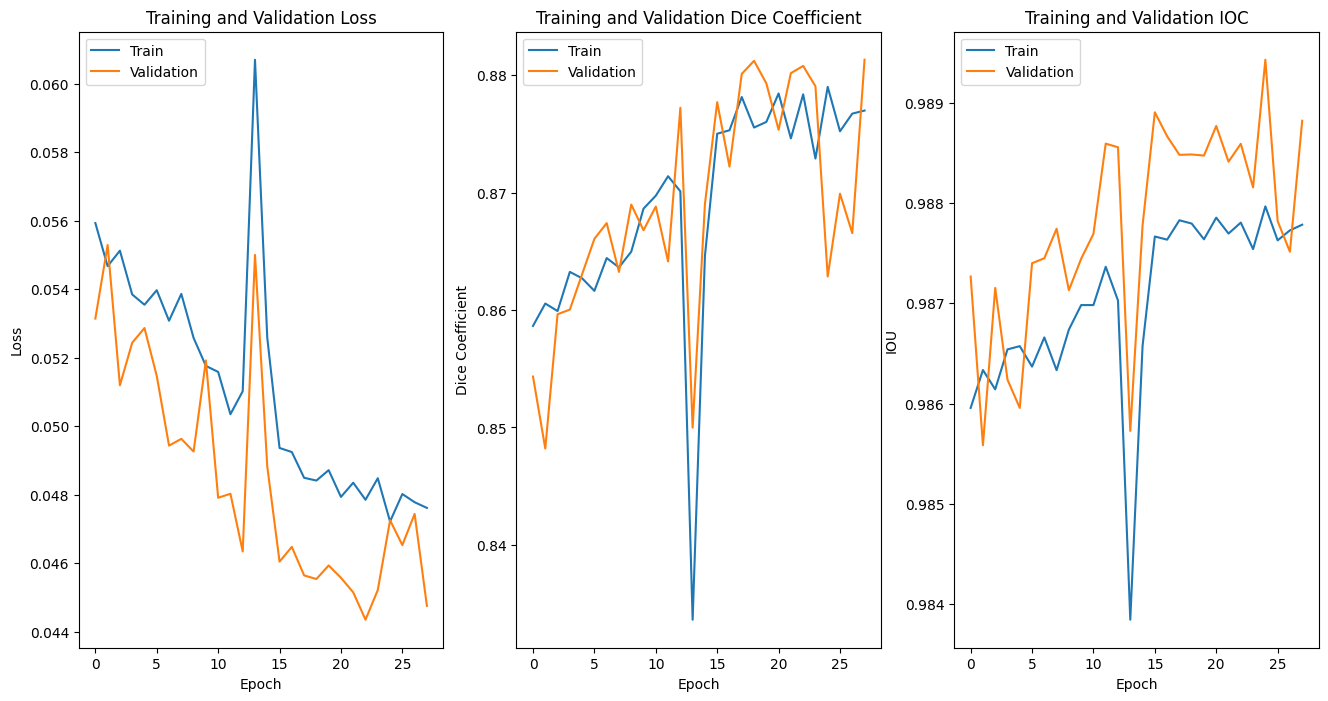

Training history keys: dict_keys(['loss', 'dice_coef', 'iou_metric', 'val_loss', 'val_dice_coef', 'val_iou_metric'])


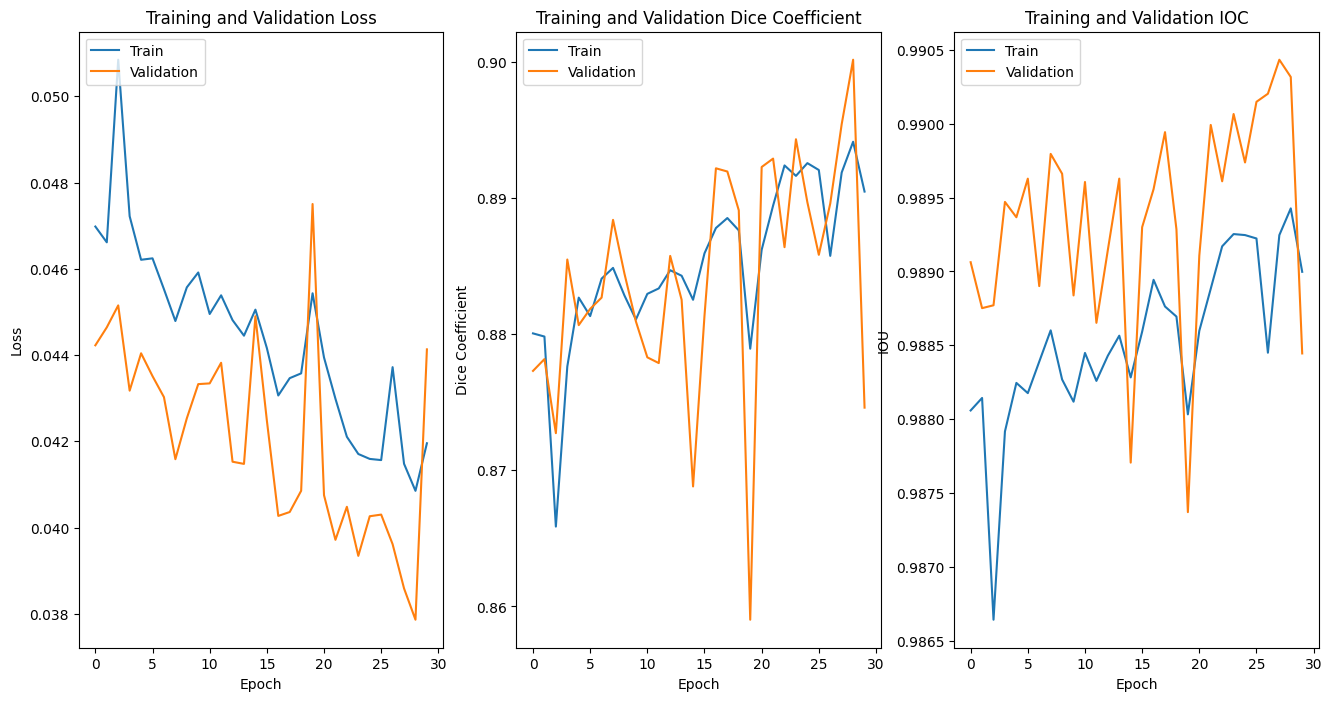

In [37]:
import matplotlib.pyplot as plt
for fold_history in all_fold_histories:
  print("Training history keys:", fold_history.history.keys())

  # Access loss and accuracy values for each epoch
  training_loss = fold_history.history['loss']
  validation_loss = fold_history.history['val_loss']

  # You can also access other metrics if specified during model compilation
  dice_coefficient = fold_history.history['dice_coef']
  val_dice_coefficient = fold_history.history['val_dice_coef']

  iou = fold_history.history['iou_metric']
  val_iou = fold_history.history['val_iou_metric']

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 3, 2)
  plt.plot(dice_coefficient, label='Training Dice Coefficient')
  plt.plot(val_dice_coefficient, label='Validation Dice Coefficient')
  plt.xlabel('Epoch')
  plt.ylabel('Dice Coefficient')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.title('Training and Validation Dice Coefficient')

  plt.subplot(1, 3, 1)
  plt.plot(training_loss, label='Training Loss')
  plt.plot(validation_loss, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.title('Training and Validation Loss')

  plt.subplot(1, 3, 3)
  plt.plot(iou, label='Training IOC')
  plt.plot(val_iou, label='Validation IOC')
  plt.xlabel('Epoch')
  plt.ylabel('IOU')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.title('Training and Validation IOC')
  plt.show()

In [ ]:
dice_coeffient = history.history['dice_coef']
val_dice_coefficient = history.history['val_dice_coef']

loss = history.history['loss']
val_loss = history.history['val_loss']

iou = history.history['iou_metric']
val_iou = history.history['val_iou_metric']

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 2)
plt.plot(dice_coeffient, label='Training Dice Coefficient')
plt.plot(val_dice_coefficient, label='Validation Dice Coefficient')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 3, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 3)
plt.plot(iou, label='Training IOC')
plt.plot(val_iou, label='Validation IOC')
plt.legend(loc='upper right')
plt.title('Training and Validation IOC')

plt.show()

In [53]:
from sklearn.metrics import f1_score

# Assuming you have a test_masks dataset
ground_truth_masks = tf.concat([mask for _, mask in test_batches], axis=0)
test_images = tf.concat([image for image, mask in test_batches], axis=0)

# Predictions from the model
predictions = wavelet_unet_model.predict(test_images)

# Flatten predictions and ground truth masks
flat_predictions = tf.reshape(predictions, [-1])
flat_ground_truth = tf.reshape(ground_truth_masks, [-1])

# Convert predictions and ground truth to binary (0 or 1)
binary_predictions = tf.cast(tf.greater(flat_predictions, 0.5), tf.float32)
binary_ground_truth = tf.cast(tf.greater(flat_ground_truth, 0.5), tf.float32)

test_f1 = f1_score(binary_ground_truth, binary_predictions, average='weighted')

# Print the results
print(f"Test F1 Score: {test_f1:.4f}")

16/16 [==============================] - 9s 565ms/step
Test F1 Score: 0.9748


In [52]:
from keras import backend as K
# Assuming you have a test_masks dataset
ground_truth_masks = tf.concat([mask for _, mask in test_batches], axis=0)
test_images = tf.concat([image for image, mask in test_batches], axis=0)

# Predictions from the model
predictions = wavelet_unet_model.predict(test_images)

# Flatten predictions and ground truth masks
flat_predictions = tf.reshape(predictions, [-1])
flat_ground_truth = tf.reshape(ground_truth_masks, [-1])

# Convert predictions and ground truth to binary (0 or 1)
binary_predictions = tf.cast(tf.greater(flat_predictions, 0.5), tf.float32)
binary_ground_truth = tf.cast(tf.greater(flat_ground_truth, 0.5), tf.float32)

# Calculate Dice coefficient
dice = dice_coef(binary_ground_truth, binary_predictions)
dice_value = dice.numpy()

print(f'Dice Coefficient on Test Data: {dice_value}')

16/16 [==============================] - 9s 568ms/step
Dice Coefficient on Test Data: 0.7252253890037537


In [51]:
from keras import backend as K
# Assuming you have a test_masks dataset
ground_truth_masks = tf.concat([mask for _, mask in test_batches], axis=0)
test_images = tf.concat([image for image, mask in test_batches], axis=0)

# Predictions from the model
predictions = wavelet_unet_model.predict(test_images)
binary_predictions
# Flatten predictions and ground truth masks
flat_predictions = tf.reshape(predictions, [-1])
flat_ground_truth = tf.reshape(ground_truth_masks, [-1])

# Convert predictions and ground truth to binary (0 or 1)
binary_predictions = tf.cast(tf.greater(flat_predictions, 0.5), tf.float32)
binary_ground_truth = tf.cast(tf.greater(flat_ground_truth, 0.5), tf.float32)

# Calculate Dice coefficient
iou = iou_metric(binary_ground_truth, binary_predictions)
iou = iou.numpy()

print(f'IOU on Test Data: {iou}')

16/16 [==============================] - 9s 565ms/step
IOU on Test Data: 0.5689048767089844


In [47]:
from sklearn.metrics import roc_auc_score

# Assuming you have a test_masks dataset (binary segmentation)
ground_truth_masks = tf.concat([mask for _, mask in test_batches], axis=0)
test_images = tf.concat([image for image, mask in test_batches], axis=0)

# Predictions from the model
predictions = wavelet_unet_model.predict(test_images)

# Flatten predictions and ground truth masks
flat_predictions = tf.reshape(predictions, [-1])
flat_ground_truth = tf.reshape(ground_truth_masks, [-1])

# Convert predictions and ground truth to binary (0 or 1)
binary_predictions = tf.cast(tf.greater(flat_predictions, 0.5), tf.float32)
binary_ground_truth = tf.cast(tf.greater(flat_ground_truth, 0.5), tf.float32)

# Calculate AUC
auc_value = roc_auc_score(binary_ground_truth.numpy(), binary_predictions.numpy())

print(f'AUC on Test Data: {auc_value}')


16/16 [==============================] - 9s 569ms/step
AUC on Test Data: 0.8389110199671671


1/1 [==============================] - 0s 28ms/step


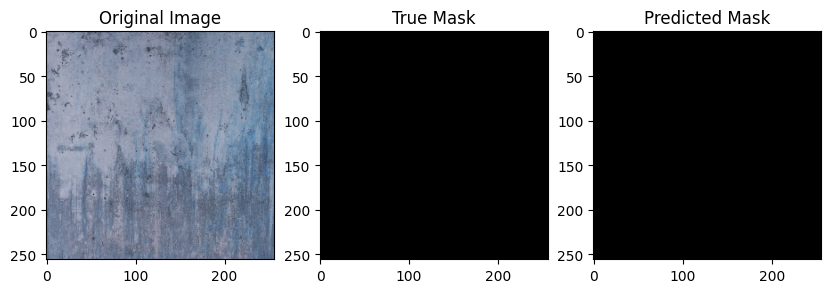

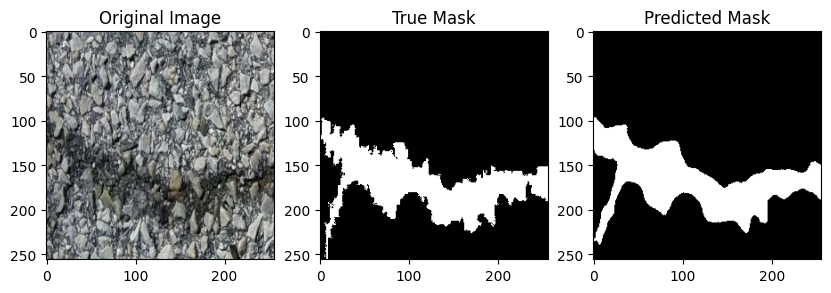

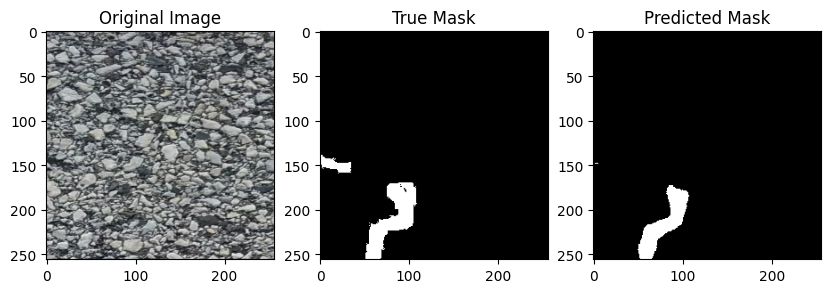

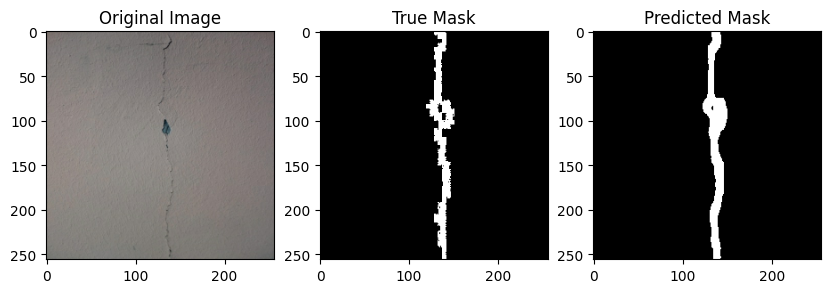

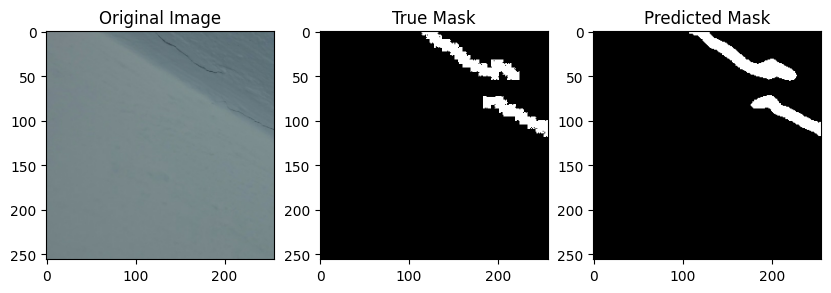

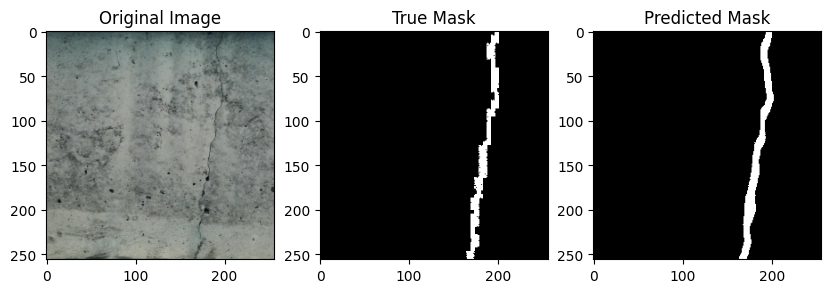

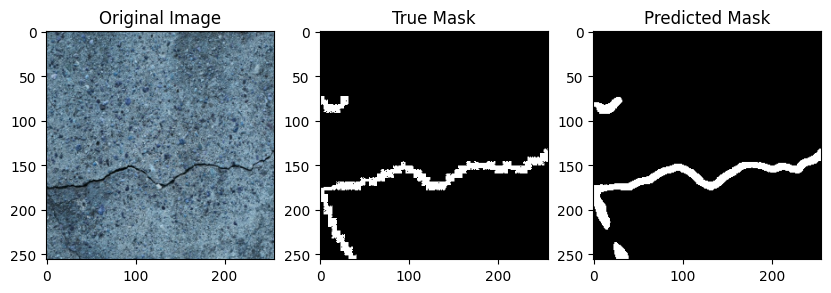

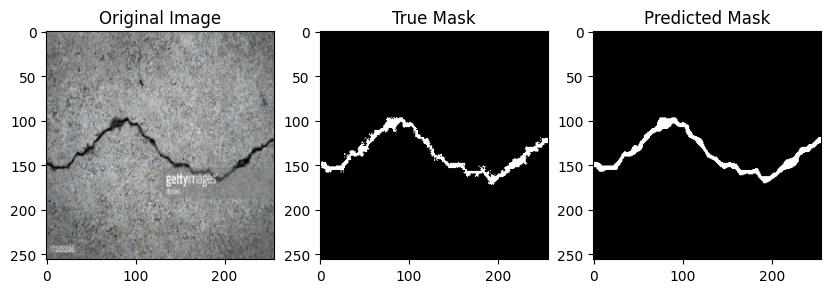

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Iterate over the test dataset and make predictions
for test_batch in fold_train_dataset.batch(BATCH_SIZE):
    images, true_masks = test_batch
    predicted_masks = wavelet_unet_model.predict(images)

    # Assuming your images and masks are in the range [0, 1]
    images = np.array(images).astype(np.uint8)
    true_masks = np.array(true_masks * 255).astype(np.uint8)
    threshold = 0.5  # Adjust this threshold based on your needs
    binary_masks = (predicted_masks >= 0.5).astype(float)
    predicted_masks = np.array(binary_masks * 255).astype(np.uint8)

    for i in range(len(images)):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title('Original Image')

        plt.subplot(1, 3, 2)
        plt.imshow(true_masks[i, :, :, 0], cmap='gray')
        plt.title('True Mask')

        plt.subplot(1, 3, 3)
        plt.imshow(predicted_masks[i, :, :, 0], cmap='gray')
        plt.title('Predicted Mask')

        plt.show()

    break;
